In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.5 MB/s eta 0:00:00


In [2]:
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 178.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tqdm import tqdm

In [3]:
file_id = '1h97krjdPVuKszy9NVcZiWNQuPUu3ICyc' #version con artist_id
url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(url)
df['fecha'] = pd.to_datetime(df['fecha'], format='%m/%d/%Y')
df.head()

,artist_id,fecha,royalties,instagram_followers,twitter_followers,track_release,sentiment,seguidores_menciones,cant_posteos,cant_comentarios,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_seguidores_menciones_3m,month
0,A01,2022-08-01,9181.530,6157095,2725818,0,0.000000,0,0,0,9181.530000,0.0000,0,0,0,0.000000,0,8
1,A01,2022-09-01,11326.315,6267740,2724330,0,0.000000,0,2,40,10253.922500,78237.8298,-1488,110645,0,0.000000,0,9
2,A01,2022-10-01,8111.670,6387042,2721716,0,0.555556,0,1,27,9539.838333,115000.6565,-2614,119302,0,0.185185,0,10
3,A01,2022-11-01,8916.570,6460584,2718405,1,0.610169,0,3,118,9384.021250,133558.2623,-3311,73542,1,0.388575,0,11
4,A01,2022-12-01,12755.920,6562667,2713392,1,0.538462,0,1,39,10058.401000,159183.7579,-5013,102083,2,0.568062,0,12


# Seleccion de Hiperparametros y Predicciones

In [ ]:
from pmdarima import auto_arima
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def detectar_mejores_parametros(df):
    resultados = []

    for artist_id, group in tqdm(df.groupby("artist_id"), desc="Buscando mejores parámetros"):
        group = group.sort_values("fecha").set_index("fecha").asfreq("MS")
        group = group.interpolate().fillna(method="bfill")

        y = group["royalties"]
        X = group.drop(columns=["artist_id", "royalties"])

        try:
            # Detectar componente estacional solo si hay 36+ meses
            seasonal_flag = len(y) >= 36

            model = auto_arima(
                y=y,
                exogenous=X,
                seasonal=seasonal_flag,
                m=12 if seasonal_flag else 1,
                d=None, D=None,
                start_p=0, start_q=0, start_P=0, start_Q=0,
                max_p=3, max_q=3, max_d=2,
                max_P=2, max_Q=2, max_D=1,
                stepwise=True,
                suppress_warnings=True,
                error_action="ignore",
                information_criterion="aicc",
                max_order=10
            )

            resultados.append({
                "artist_id": artist_id,
                "order": model.order,
                "seasonal_order": model.seasonal_order if seasonal_flag else (0, 0, 0, 0),
                "aicc": model.aicc()
            })

        except Exception as e:
            resultados.append({
                "artist_id": artist_id,
                "order": None,
                "seasonal_order": None,
                "aicc": None,
                "error": str(e)
            })

    df_best = pd.DataFrame(resultados)
    df_best.to_csv("sarimax_best_params_por_artista.csv", index=False)
    print("✅ Archivo generado: sarimax_best_params_por_artista.csv")
    return df_best


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

def forecast_walkforward_sarimax(df, best_params, train_init=18, step=6):
    resultados = []
    predicciones = []

    for artist_id, group in tqdm(df.groupby("artist_id"), desc="Walk-forward SARIMAX"):
        group = group.sort_values("fecha").set_index("fecha").asfreq("MS")
        group = group.interpolate().fillna(method="bfill")

        y_full = group["royalties"]
        X_full = group.drop(columns=["artist_id", "royalties"])
        n = len(y_full)

        # Recuperar parámetros pre-calculados
        params_row = best_params[best_params["artist_id"] == artist_id]
        if params_row.empty:
            continue

        order_raw = params_row.iloc[0]["order"]
        seasonal_raw = params_row.iloc[0]["seasonal_order"]

        if isinstance(order_raw, str):
            order = eval(order_raw)
        else:
            order = order_raw

        if isinstance(seasonal_raw, str):
            seasonal_order = eval(seasonal_raw)
        else:
            seasonal_order = seasonal_raw

        # Normalizar
        if seasonal_order is None or (len(seasonal_order) == 4 and seasonal_order[3] < 2):
            seasonal_order = (0, 0, 0, 0)


        if n < train_init + step:
            resultados.append({
                "artist_id": artist_id,
                "iteracion": None,
                "rmse": None,
                "mape": None,
                "error": "Serie demasiado corta"
            })
            continue

        # Walk-forward con órdenes fijos
        for i in range(train_init, n - step + 1, step):
            y_train = y_full.iloc[:i]
            X_train = X_full.iloc[:i]
            y_valid = y_full.iloc[i:i+step]
            X_valid = X_full.iloc[i:i+step]

            try:
                model = SARIMAX(
                    y_train,
                    exog=X_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                y_pred = model.forecast(steps=step, exog=X_valid)

                rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
                mape = mean_absolute_percentage_error(y_valid, y_pred)

                resultados.append({
                    "artist_id": artist_id,
                    "iteracion": i,
                    "order": order,
                    "seasonal_order": seasonal_order,
                    "rmse": rmse,
                    "mape": mape,
                    "error": None
                })

                pred_df = pd.DataFrame({
                    "artist_id": artist_id,
                    "fecha": y_valid.index,
                    "royalties_real": y_valid.values,
                    "royalties_pred": y_pred
                })
                predicciones.append(pred_df)

            except Exception as e:
                resultados.append({
                    "artist_id": artist_id,
                    "iteracion": i,
                    "order": order,
                    "seasonal_order": seasonal_order,
                    "rmse": None,
                    "mape": None,
                    "error": str(e)
                })

    df_resultados = pd.DataFrame(resultados)
    df_predicciones = pd.concat(predicciones, ignore_index=True) if predicciones else pd.DataFrame()
    df_predicciones = (
        df_predicciones
        .assign(modelo='SARIMAX')
        )


    # Guardar resultados
    #df_resultados.to_csv("sarimax_walkforward_resultados.csv", index=False)
    df_predicciones.to_csv("sarimax_predicciones_para_powerbi.csv", index=False)
    print("✅ Archivos generados:")
    #print("- sarimax_walkforward_resultados.csv")
    print("- sarimax_predicciones_para_powerbi.csv")

    return df_resultados, df_predicciones


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

def calcular_metricas_por_artista(df_resultados):
    """
    Calcula métricas promedio por artista a partir de los resultados del walk-forward.
    """
    df_validos = df_resultados.dropna(subset=["mape", "rmse"])
    if df_validos.empty:
        print("⚠️ No se encontraron resultados válidos para calcular métricas.")
        return pd.DataFrame()

    resumen = (
        df_validos.groupby("artist_id")
        .agg({
            "rmse": "mean",
            "mape": "mean"
        })
        .reset_index()
        .rename(columns={
            "artist_id": "Artist_ID",
            "rmse": "RMSE",
            "mape": "MAPE"
        })
    )

    # Agregar nombre del modelo
    resumen["Modelo"] = "SARIMAX"

    # Calcular métricas adicionales
    resumen["MSE"] = resumen["RMSE"] ** 2
    resumen["MAE"] = np.sqrt(resumen["MSE"])

    # Reordenar columnas
    resumen = resumen[["Artist_ID", "Modelo", "MSE", "MAE", "RMSE", "MAPE"]]

    # Exportar CSV
    resumen.to_csv("sarimax_metrics_por_artista.csv", index=False)
    print("✅ Archivo generado: sarimax_metrics_por_artista.csv")

    return resumen


In [ ]:
# Preparar dataset
df["fecha"] = pd.to_datetime(df["fecha"])
df = df.sort_values(["artist_id", "fecha"])

# 1️⃣ Detectar parámetros globales
best_params = detectar_mejores_parametros(df)
print(best_params)


Buscando mejores parámetros: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

✅ Archivo generado: sarimax_best_params_por_artista.csv
   artist_id      order seasonal_order         aicc
0        A01  (0, 1, 0)   (0, 0, 0, 0)   554.827084
1        A02  (0, 1, 1)   (0, 0, 0, 0)   511.511899
2        A03  (1, 0, 0)   (0, 0, 0, 0)   773.121934
3        A04  (1, 0, 0)   (0, 0, 0, 0)   492.059902
4        A05  (0, 0, 0)  (0, 0, 0, 12)  1012.802780
5        A06  (1, 0, 0)   (0, 0, 0, 0)   758.717271
6        A07  (0, 1, 0)  (0, 0, 0, 12)  1007.834060
7        A08  (0, 1, 0)   (0, 0, 0, 0)   584.189362
8        A09  (1, 1, 0)   (0, 0, 0, 0)   565.043963
9        A10  (1, 1, 0)   (0, 0, 0, 0)   552.891899
10       A11  (0, 0, 0)  (0, 0, 0, 12)   842.732266
11       A12  (0, 1, 0)  (0, 0, 0, 12)   566.215591
12       A13  (1, 0, 1)  (0, 0, 1, 12)  1130.345873
13       A14  (0, 1, 0)   (0, 0, 0, 0)   705.233601
14       A15  (0, 0, 0)  (0, 0, 0, 12)  1001.187768


In [ ]:
resultados_sarimax, predicciones_sarimax = forecast_walkforward_sarimax(df, best_params)

Walk-forward SARIMAX: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

✅ Archivos generados:
- sarimax_predicciones_para_powerbi.csv


In [ ]:
metricas_por_artista = calcular_metricas_por_artista(resultados_sarimax)
metricas_por_artista


✅ Archivo generado: sarimax_metrics_por_artista.csv


,Artist_ID,Modelo,MSE,MAE,RMSE,MAPE
0,A01,SARIMAX,2.570176e+07,5.069690e+03,5.069690e+03,0.879858
1,A02,SARIMAX,3.855836e+07,6.209537e+03,6.209537e+03,0.809845
2,A03,SARIMAX,9.802454e+10,3.130887e+05,3.130887e+05,0.340418
3,A04,SARIMAX,5.848843e+06,2.418438e+03,2.418438e+03,0.637687
4,A05,SARIMAX,1.937525e+10,1.391950e+05,1.391950e+05,0.350152
5,A06,SARIMAX,3.894806e+09,6.240838e+04,6.240838e+04,0.407730
6,A07,SARIMAX,1.666916e+10,1.291091e+05,1.291091e+05,0.169827
7,A08,SARIMAX,9.277362e+07,9.631906e+03,9.631906e+03,0.279312
8,A09,SARIMAX,6.784487e+06,2.604705e+03,2.604705e+03,0.155525
9,A10,SARIMAX,5.224945e+07,7.228378e+03,7.228378e+03,0.480502


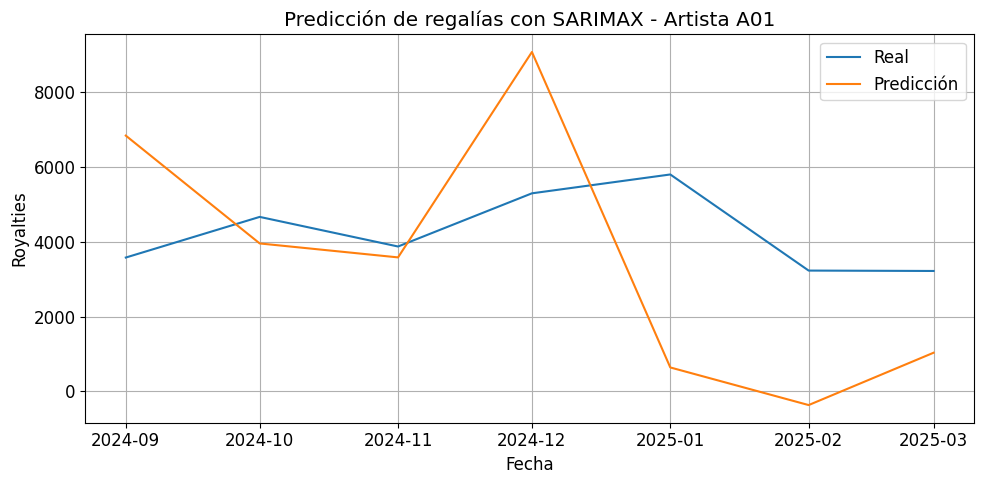

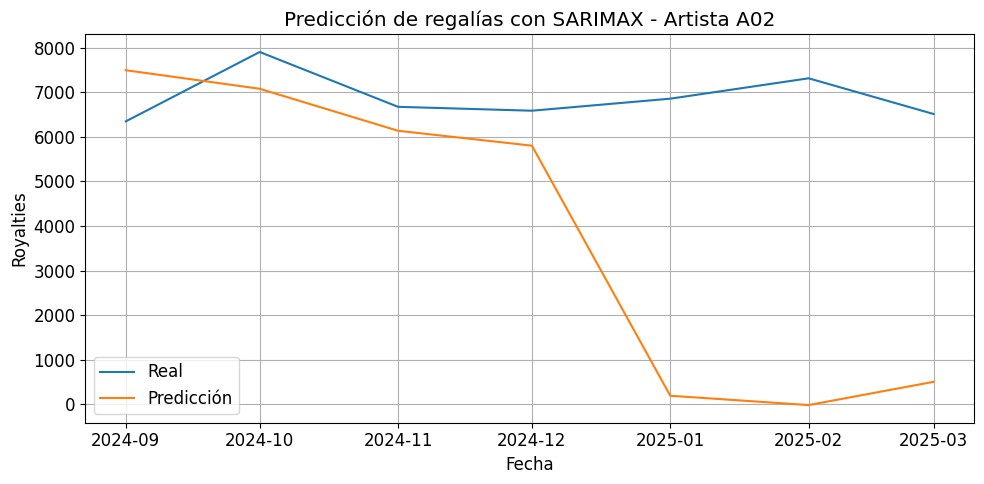

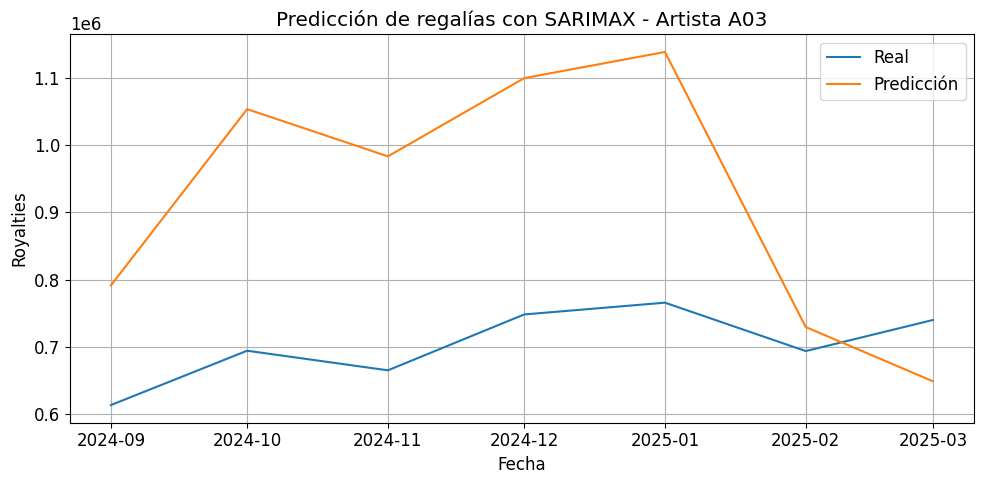

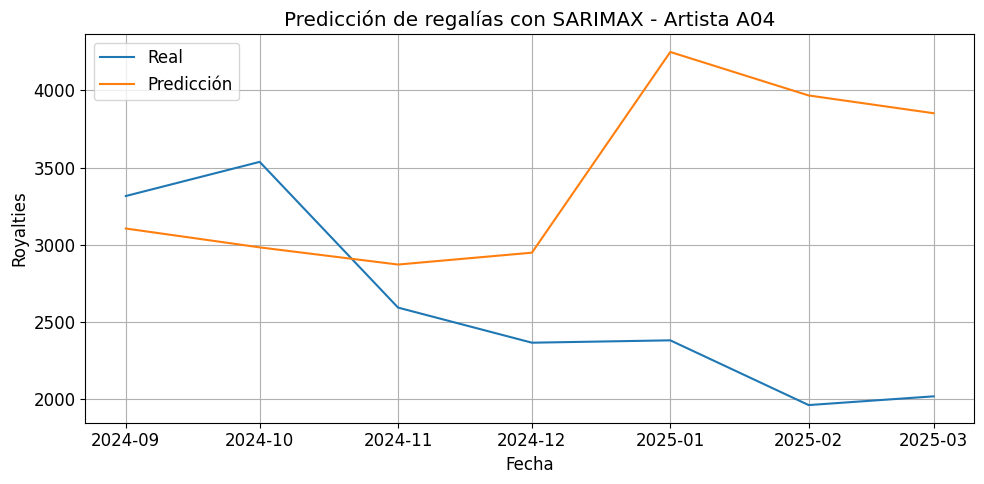

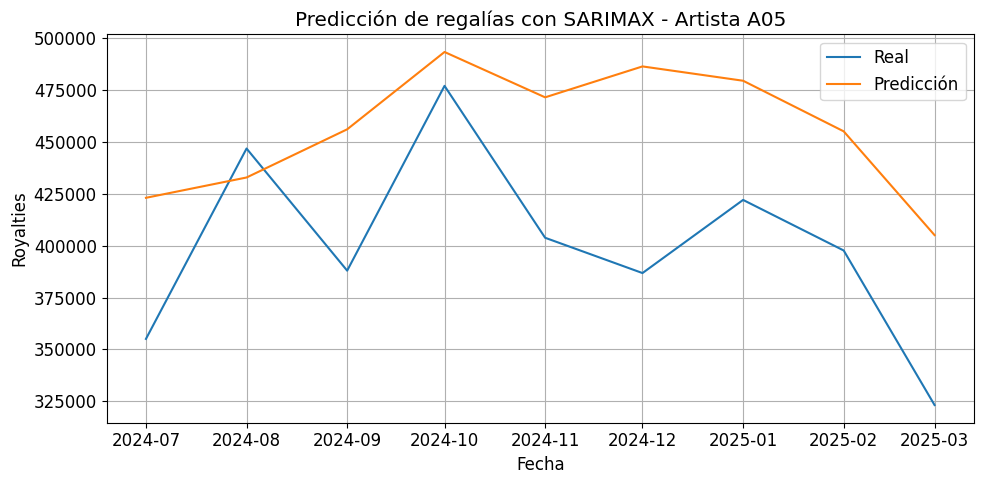

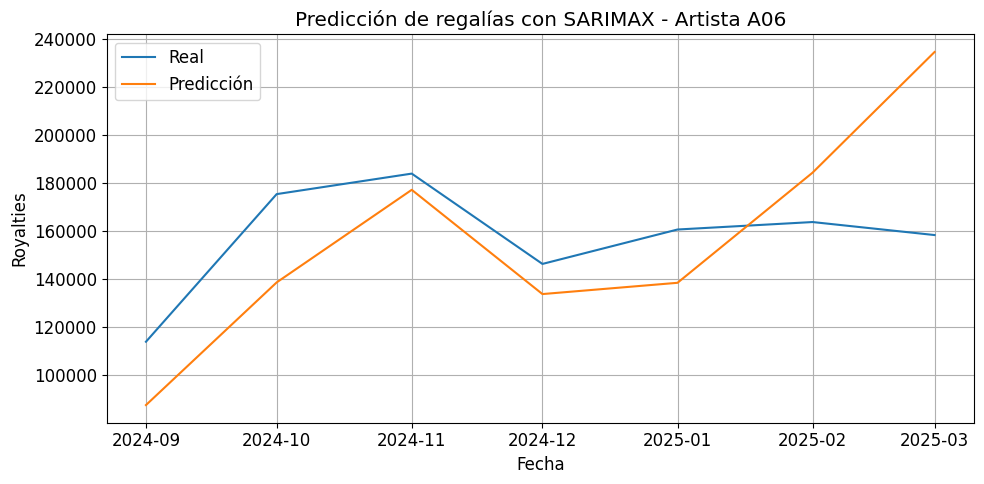

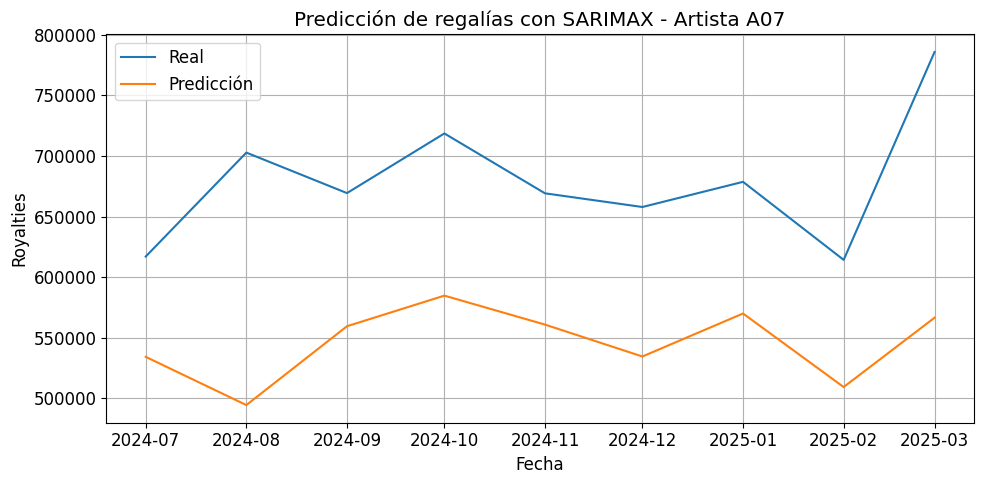

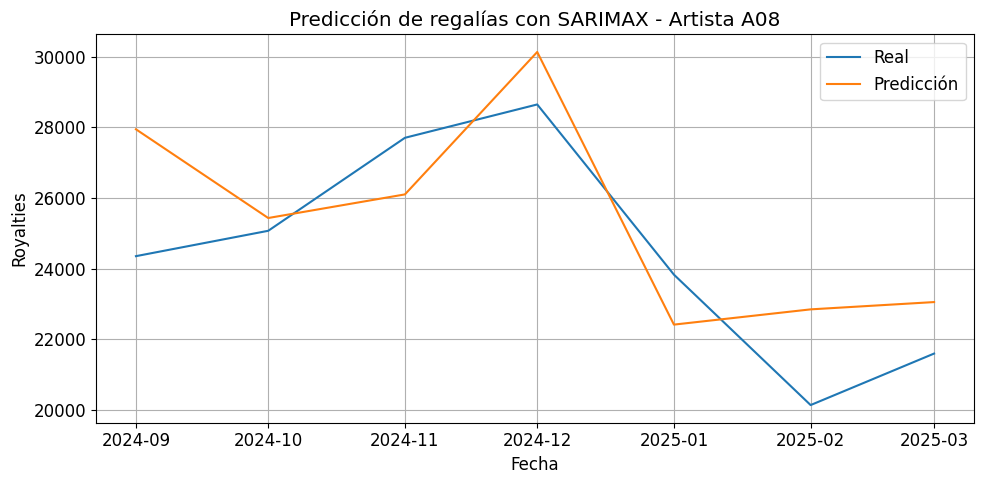

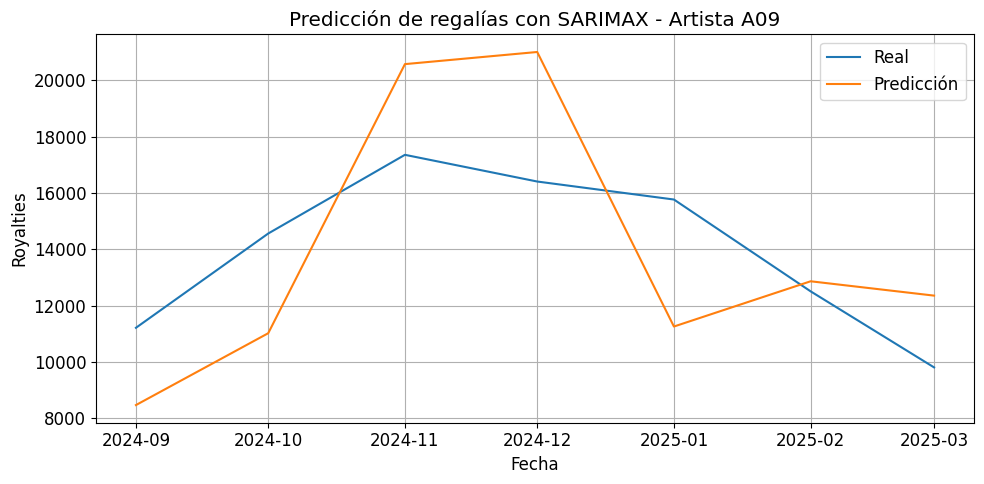

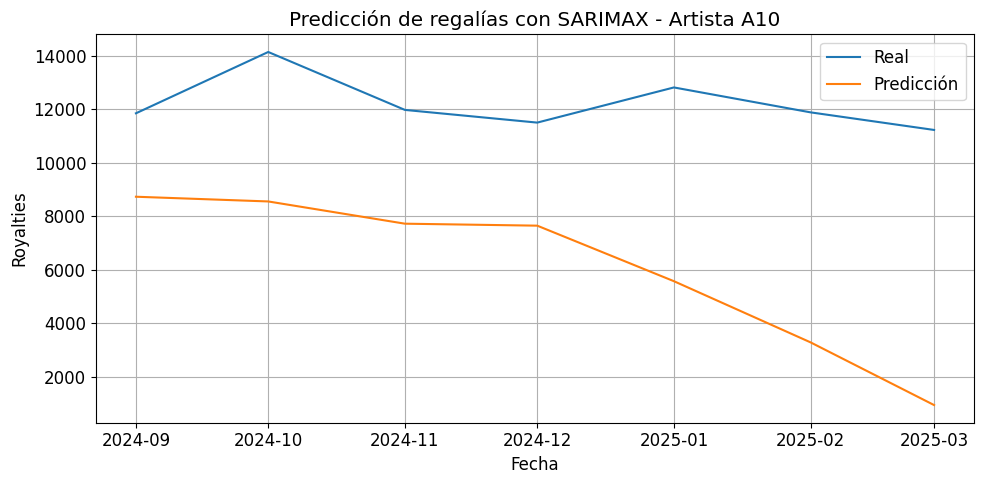

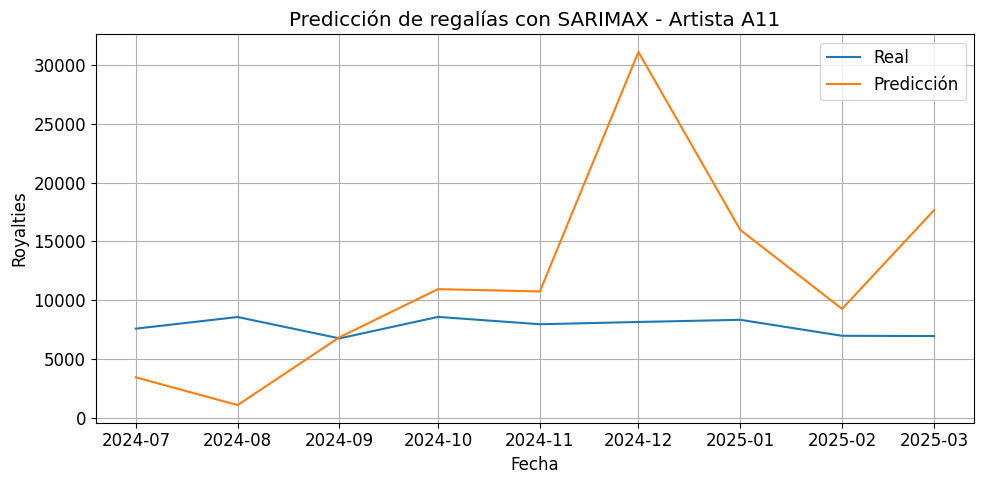

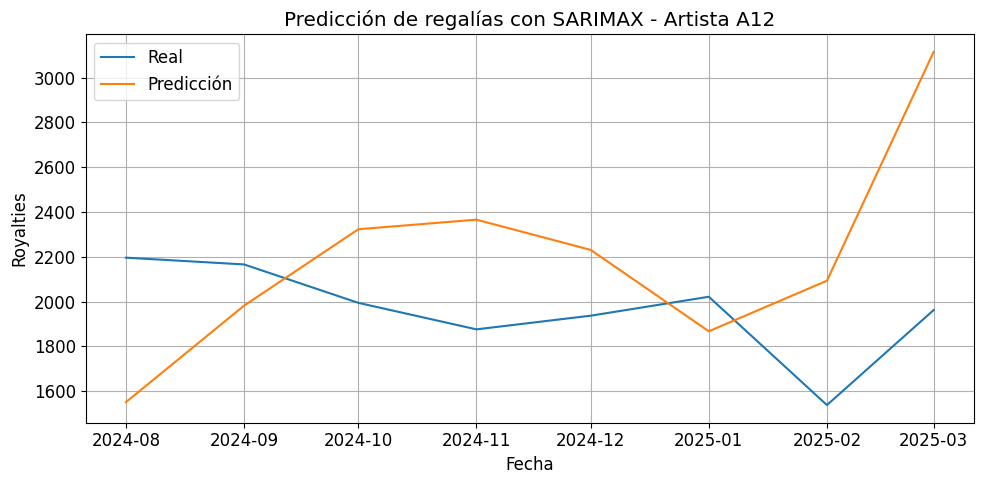

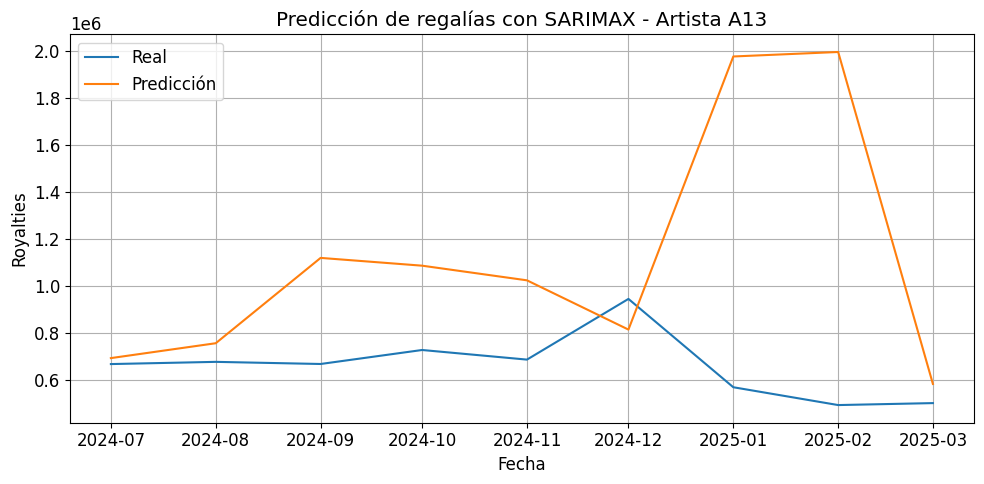

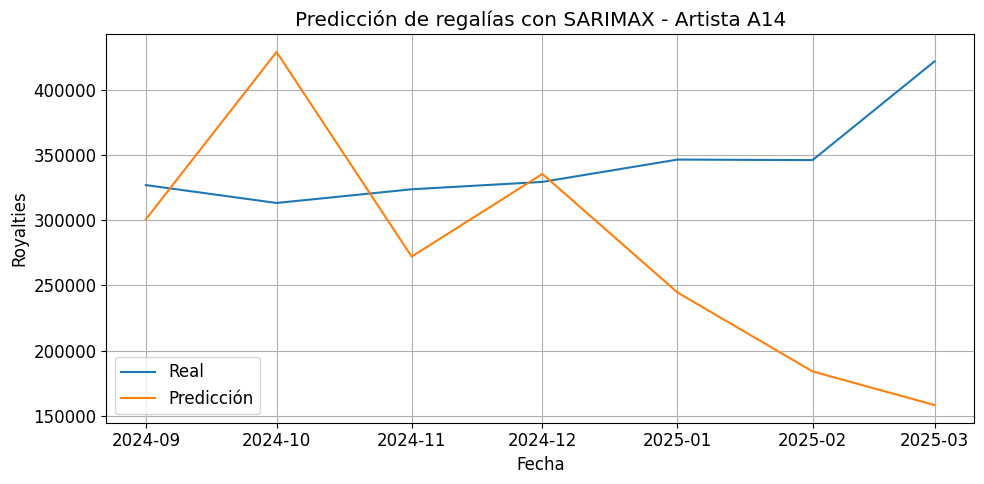

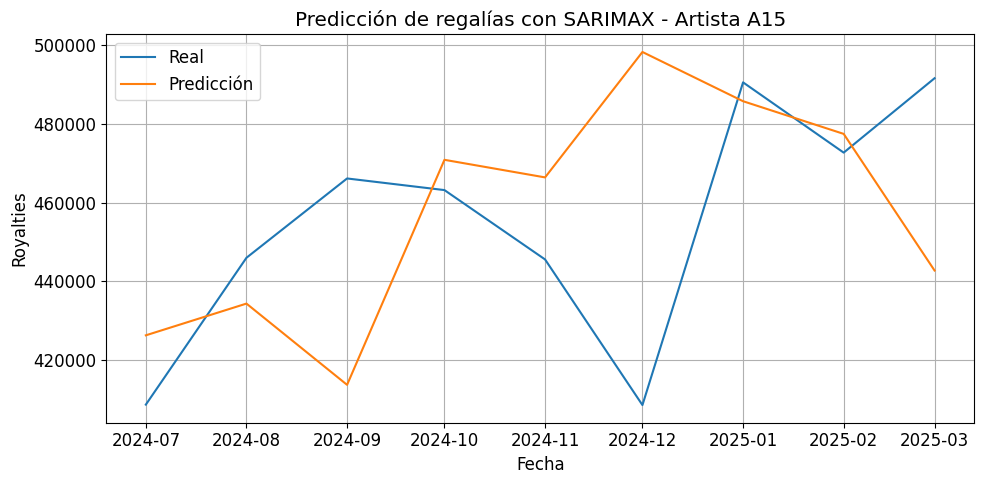

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo con predicciones
predicciones_sarimax = pd.read_csv("sarimax_predicciones_para_powerbi.csv")
predicciones_sarimax["fecha"] = pd.to_datetime(predicciones_sarimax["fecha"])

# Configuración general de estilo
plt.rcParams.update({
    "font.size": 12,
    "figure.figsize": (10, 5),
    "axes.grid": True
})

# Mostrar todos los gráficos (uno por artista)
for artist_id, group in predicciones_sarimax.groupby("artist_id"):
    group = group.sort_values("fecha")

    plt.figure()
    plt.plot(group["fecha"], group["royalties_real"], label="Real")#, color="black", linewidth=2)
    plt.plot(group["fecha"], group["royalties_pred"], label="Predicción")#, color="royalblue", linestyle="--", linewidth=2)

    plt.title(f"Predicción de regalías con SARIMAX - Artista {artist_id}")
    plt.xlabel("Fecha")
    plt.ylabel("Royalties")
    plt.legend()
    plt.tight_layout()
    plt.show()  # 👈 muestra el gráfico en pantalla


# Forecast

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# ==========================================
# CONFIGURACIÓN
# ==========================================
FORECAST_STEPS = 6
BEST_PARAMS_CSV = "sarimax_best_params_por_artista.csv"

# Estrategia de exógenas:
#   - "hold"   -> mantiene último valor
#   - "growth" -> crecimiento uniforme en TODAS las numéricas (tu implementación original)
#   - "lstm_style" -> +1%/mes SOLO followers; track_release=0; resto hold (como tu LSTM)
EXOG_STRATEGY = "lstm_style"
GROWTH_RATE = 0.01         # usado por "growth" y por "lstm_style" para followers
DEBUG_PRINTS = False        # imprime chequeos útiles de fechas/columnas

# ==========================================
# UTILIDADES
# ==========================================
def _fix_seasonal_order(seasonal_order):
    """Si s < 2, eliminar componente estacional."""
    so = list(seasonal_order) if isinstance(seasonal_order, (list, tuple)) else [0,0,0,0]
    if len(so) < 4 or so[3] < 2:
        return (0,0,0,0)
    return tuple(so)

def _build_X_future_hold(last_row: pd.Series, cols, steps=6, start_date=None):
    idx = pd.date_range(start=start_date, periods=steps, freq="MS")
    Xf = pd.DataFrame({c: [last_row[c]] * steps for c in cols}, index=idx)
    if "month" in Xf.columns:
        Xf["month"] = Xf.index.month
    return Xf

def _build_X_future_growth(last_row: pd.Series, cols, steps=6, growth_rate=0.01, start_date=None):
    idx = pd.date_range(start=start_date, periods=steps, freq="MS")
    data = {}
    for c in cols:
        v = last_row[c]
        if np.issubdtype(type(v), np.number):
            data[c] = [v * ((1 + growth_rate) ** i) for i in range(1, steps + 1)]
        else:
            data[c] = [v] * steps
    Xf = pd.DataFrame(data, index=idx)
    if "month" in Xf.columns:
        Xf["month"] = Xf.index.month
    return Xf

def _build_X_future_lstm_style(last_row: pd.Series, cols, steps=6, followers_growth=0.01, start_date=None):
    """
    Lógica LSTM:
      - instagram_followers / twitter_followers: +followers_growth mensual
      - track_release = 0
      - month = mes del índice
      - resto HOLD (último valor histórico)
    """
    idx = pd.date_range(start=start_date, periods=steps, freq="MS")

    follower_cols = [c for c in ["instagram_followers","twitter_followers"] if c in cols]
    count_like = [c for c in ["seguidores_menciones","cant_posteos","cant_comentarios"] if c in cols]
    binary_cols = [c for c in ["track_release"] if c in cols]

    data = {}
    for c in cols:
        v = last_row[c]
        if c in follower_cols and pd.notna(v):
            data[c] = [float(v) * ((1 + followers_growth) ** i) for i in range(1, steps + 1)]
        else:
            data[c] = [v] * steps

    Xf = pd.DataFrame(data, index=idx)

    # Ajustes LSTM-style
    if "track_release" in Xf.columns:
        Xf["track_release"] = 0

    if "month" in Xf.columns:
        Xf["month"] = Xf.index.month

    # Limpiezas seguras
    if "sentiment" in Xf.columns:
        Xf["sentiment"] = pd.to_numeric(Xf["sentiment"], errors="coerce").fillna(0).clip(-0.95, 0.95)

    for c in count_like:
        Xf[c] = pd.to_numeric(Xf[c], errors="coerce").fillna(0).round().clip(lower=0).astype(int)

    for c in binary_cols:
        Xf[c] = pd.to_numeric(Xf[c], errors="coerce").fillna(0).round().clip(0,1).astype(int)

    # sum_track_releases_6m coherente (si existe, y track_release=0 => queda 0)
    if "sum_track_releases_6m" in Xf.columns:
        Xf["sum_track_releases_6m"] = 0

    return Xf

def _build_X_future(last_row: pd.Series, cols, steps=6, strategy="hold", growth_rate=0.01, start_date=None):
    """Router de estrategias."""
    if strategy == "hold":
        return _build_X_future_hold(last_row, cols, steps, start_date)
    elif strategy == "growth":
        return _build_X_future_growth(last_row, cols, steps, growth_rate, start_date)
    elif strategy == "lstm_style":
        return _build_X_future_lstm_style(last_row, cols, steps, followers_growth=growth_rate, start_date=start_date)
    else:
        raise ValueError(f"Estrategia exógena no soportada: {strategy}")

# ==========================================
# FORECAST 6 MESES FUTUROS
# ==========================================
def forecast_6m_sarimax(df, best_params_path=BEST_PARAMS_CSV, steps=FORECAST_STEPS,
                        exog_strategy=EXOG_STRATEGY, growth_rate=GROWTH_RATE, debug=DEBUG_PRINTS):
    """
    Para cada artista:
      1) Usa hiperparámetros ganadores (p,d,q)(P,D,Q,s)
      2) Ajusta SARIMAX con TODO el histórico
      3) Construye X_future según estrategia (hold/growth/lstm_style)
      4) Pronostica próximos 6 meses
    """
    best_params = pd.read_csv(best_params_path)
    out_rows = []

    # =======================
    # 🧹 Limpieza global
    # =======================
    df = df.copy()
    df["fecha"] = pd.to_datetime(df["fecha"])
    df = (
        df.sort_values(["artist_id", "fecha"])
          .groupby(["artist_id", "fecha"], as_index=False)
          .mean(numeric_only=True)    # promedia si hay duplicados
    )

    # =======================
    # LOOP POR ARTISTA
    # =======================
    for _, row in tqdm(best_params.iterrows(), total=len(best_params), desc=f"Forecast 6m ({exog_strategy})"):
        artist_id = row["artist_id"]
        order = eval(row["order"]) if isinstance(row["order"], str) else (0,1,0)
        seasonal_order = eval(row["seasonal_order"]) if isinstance(row["seasonal_order"], str) else (0,0,0,0)
        seasonal_order_fixed = _fix_seasonal_order(seasonal_order)

        g = df[df["artist_id"] == artist_id].copy()
        if g.empty:
            continue

        g = g.sort_values("fecha").set_index("fecha").asfreq("MS")
        y = g["royalties"].astype(float)
        X = g.drop(columns=["artist_id", "royalties"], errors="ignore")

        # asegurar tipos numéricos y sin NaNs
        X = X.apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(method="bfill")

        last_date = y.index.max()
        X_future = _build_X_future(
            last_row=X.iloc[-1],
            cols=X.columns,
            steps=steps,
            strategy=exog_strategy,
            growth_rate=growth_rate,
            start_date=last_date + pd.offsets.MonthBegin(1)
        )

        # Asegurar MISMO orden y dtype
        X_future = X_future.reindex(columns=X.columns)
        X_future = X_future.apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(method="bfill")

        if debug:
            print(f"\n🎨 Artista {artist_id} | Estrategia: {exog_strategy}")
            print("Últimas fechas hist:", y.index[-3:].tolist())
            print("Primeras fechas fut:", X_future.index[:3].tolist())
            print("Cols X fit:", list(X.columns))
            print("Cols X_future:", list(X_future.columns))
            print("Head X_future:\n", X_future.head(2))

        try:
            model = SARIMAX(
                endog=y,
                exog=X,
                order=order,
                seasonal_order=seasonal_order_fixed,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = model.fit(disp=False)

            fc = res.get_forecast(steps=steps, exog=X_future)
            mean_fc = fc.predicted_mean
            conf80 = fc.conf_int(alpha=0.20)
            conf95 = fc.conf_int(alpha=0.05)

            tmp = pd.DataFrame({
                "artist_id": artist_id,
                "fecha": mean_fc.index,
                "forecast_royalties": mean_fc.values,
                "lo80": conf80.iloc[:, 0].values,
                "hi80": conf80.iloc[:, 1].values,
                "lo95": conf95.iloc[:, 0].values,
                "hi95": conf95.iloc[:, 1].values,
                "order": [order]*steps,
                "seasonal_order": [seasonal_order_fixed]*steps,
                "exog_strategy": [exog_strategy]*steps
            })
            out_rows.append(tmp)

        except Exception as e:
            future_idx = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=steps, freq="MS")
            err_df = pd.DataFrame({
                "artist_id": artist_id,
                "fecha": future_idx,
                "forecast_royalties": np.nan,
                "lo80": np.nan, "hi80": np.nan,
                "lo95": np.nan, "hi95": np.nan,
                "order": [order]*steps,
                "seasonal_order": [seasonal_order_fixed]*steps,
                "exog_strategy": [exog_strategy]*steps,
                "error": [str(e)]*steps,
            })
            out_rows.append(err_df)

    df_forecast = pd.concat(out_rows, ignore_index=True) if out_rows else pd.DataFrame()
    return df_forecast

# ==========================================
# USO
# ==========================================
# Cambiá EXOG_STRATEGY arriba si querés "hold" o "growth".
forecast_lstm_style = forecast_6m_sarimax(
    df, BEST_PARAMS_CSV, steps=FORECAST_STEPS,
    exog_strategy=EXOG_STRATEGY, growth_rate=GROWTH_RATE, debug=DEBUG_PRINTS
)

# Lista de columnas que querés conservar
columnas_necesarias = ['artist_id', 'fecha', 'forecast_royalties', 'lo80', 'hi80']

forecast_csv_PBI = forecast_lstm_style[columnas_necesarias].copy()
forecast_csv_PBI = (
    forecast_csv_PBI
    .assign(modelo='SARIMAX')
    .rename(columns={'lo80': 'lower_ci', 'hi80': 'upper_ci', 'fecha': 'fecha_prediccion', 'forecast_royalties': 'royalties_forecast'})
)


forecast_csv_PBI.to_csv("sarimax_forecast_royalties_artistas.csv", index=False)
print("✅ Forecast generado y guardado como 'sarimax_forecast_royalties_artistas.csv'")


Forecast 6m (lstm_style): 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]

✅ Forecast generado y guardado como 'sarimax_forecast_royalties_artistas.csv'


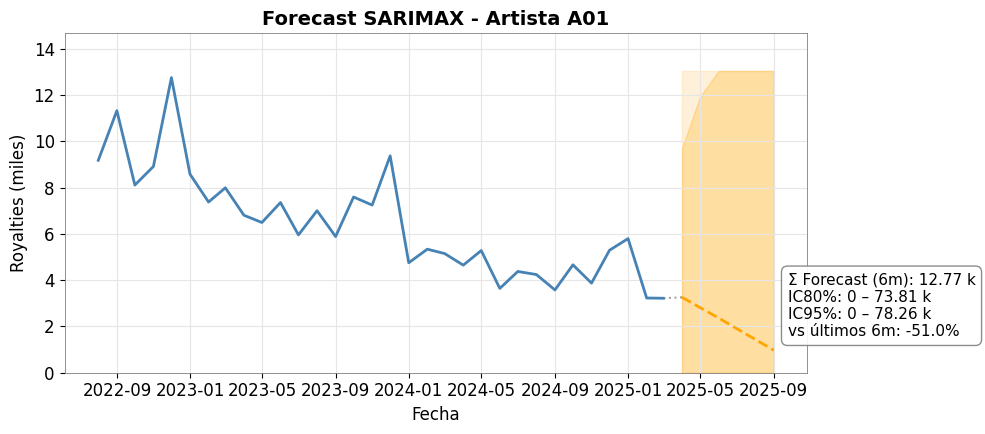

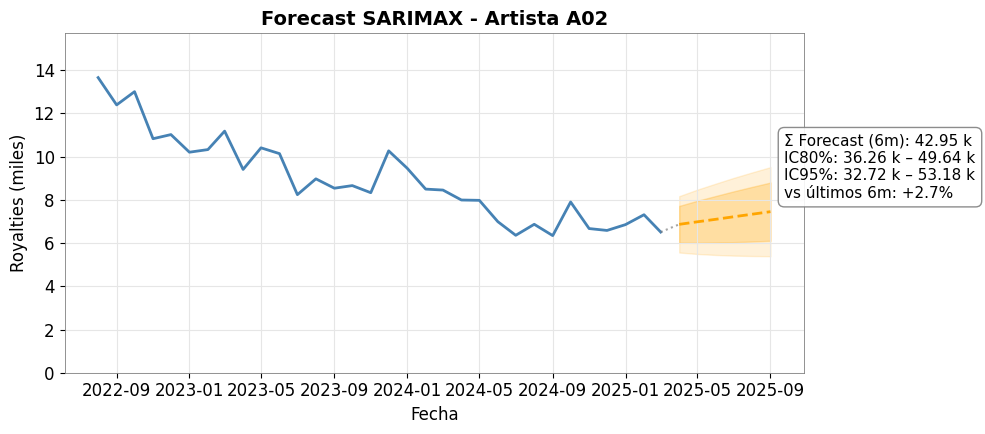

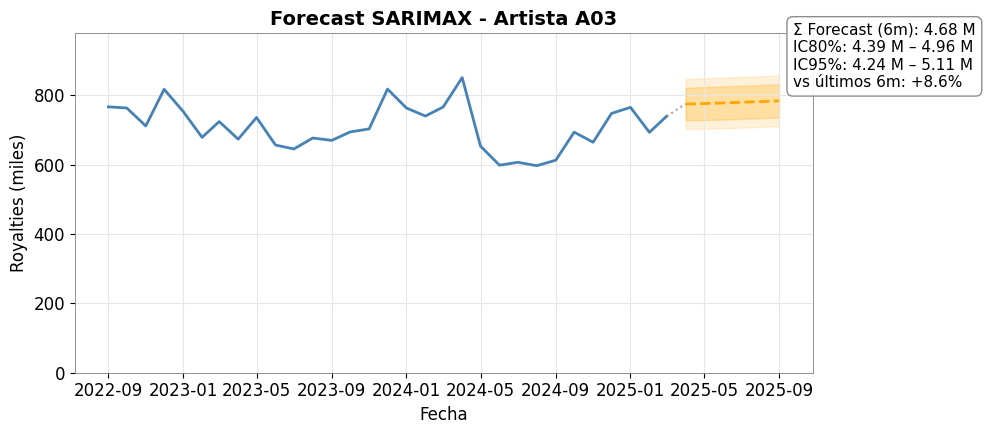

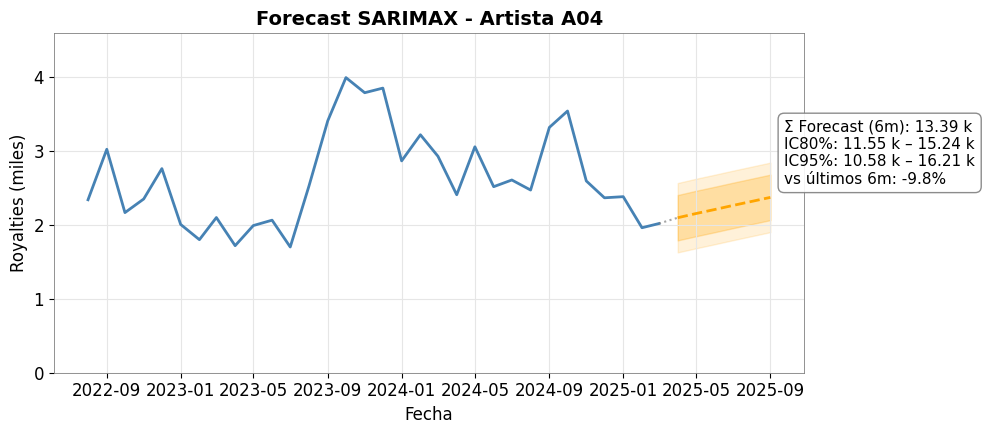

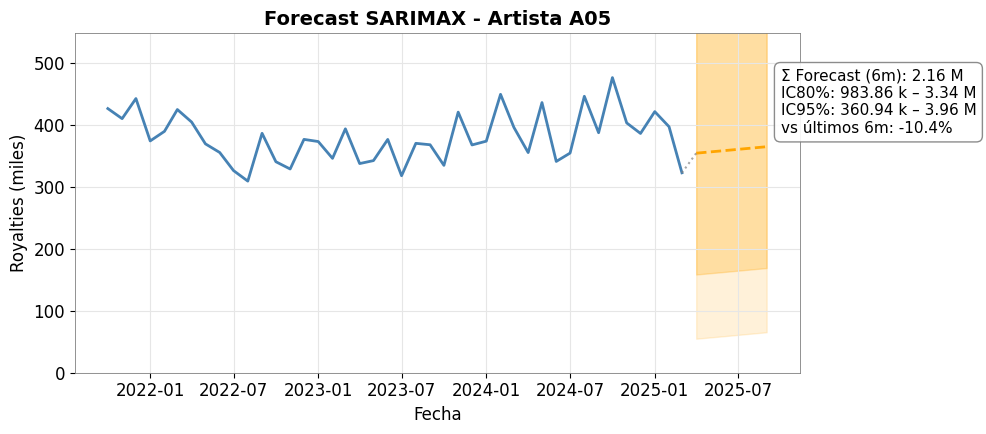

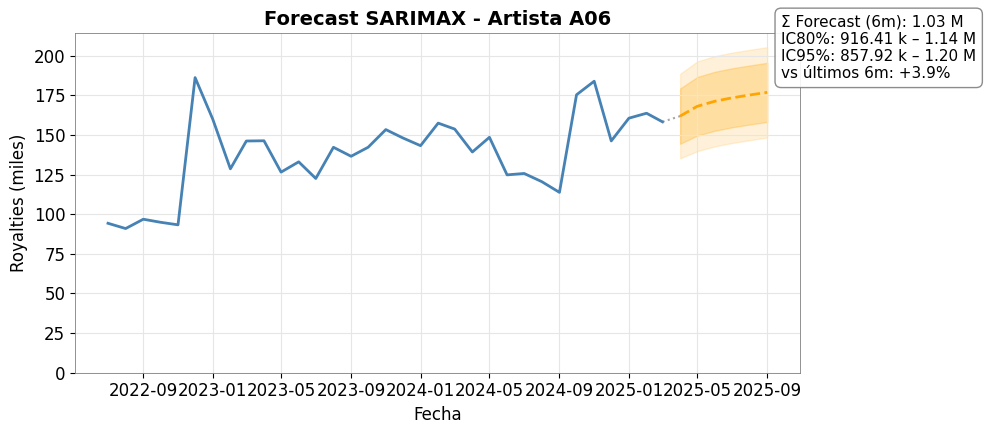

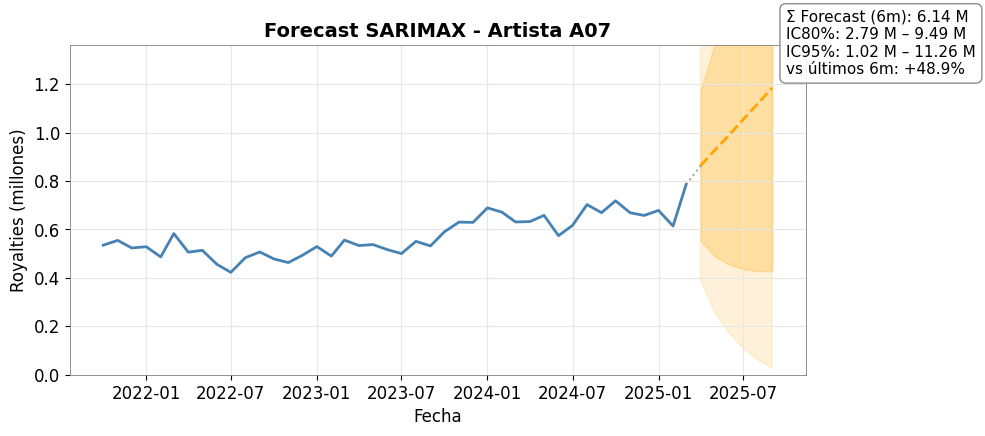

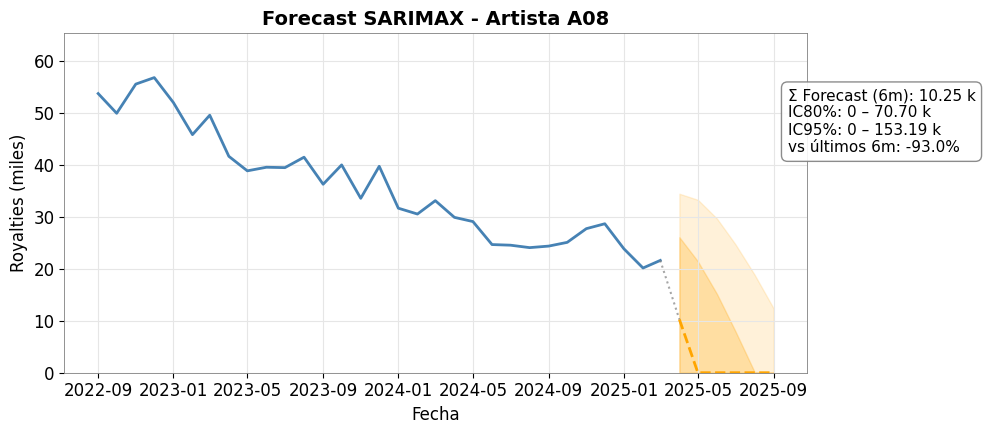

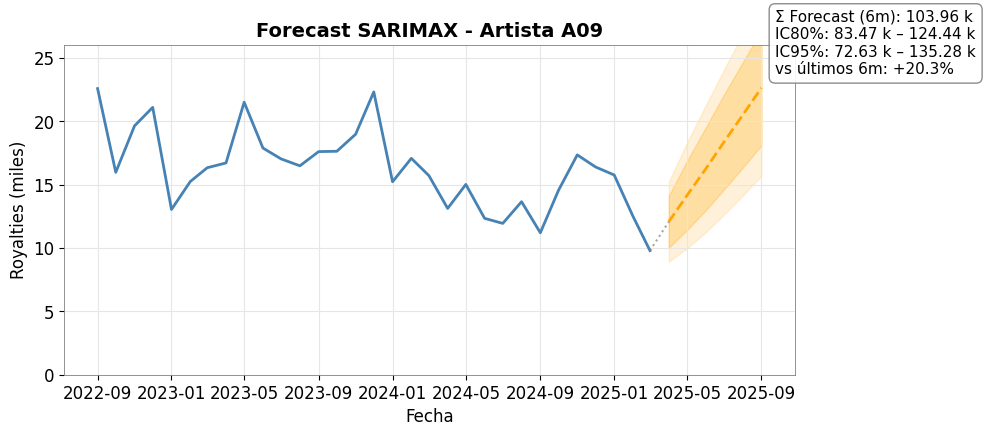

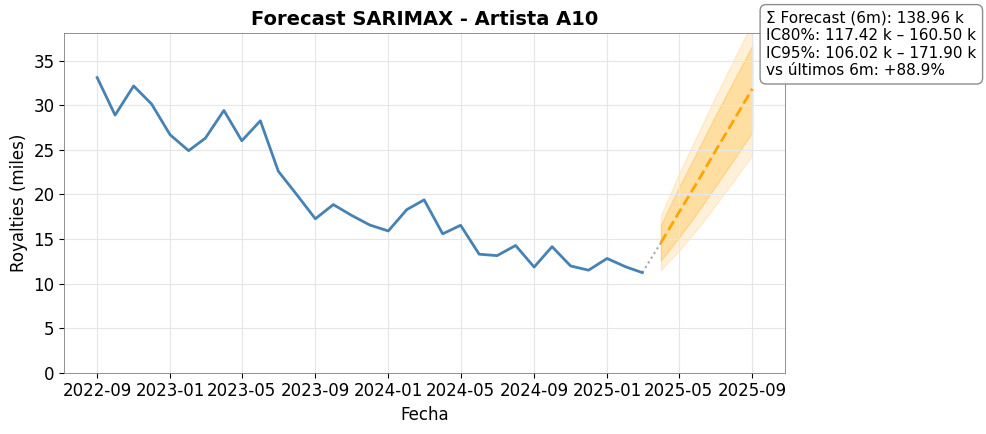

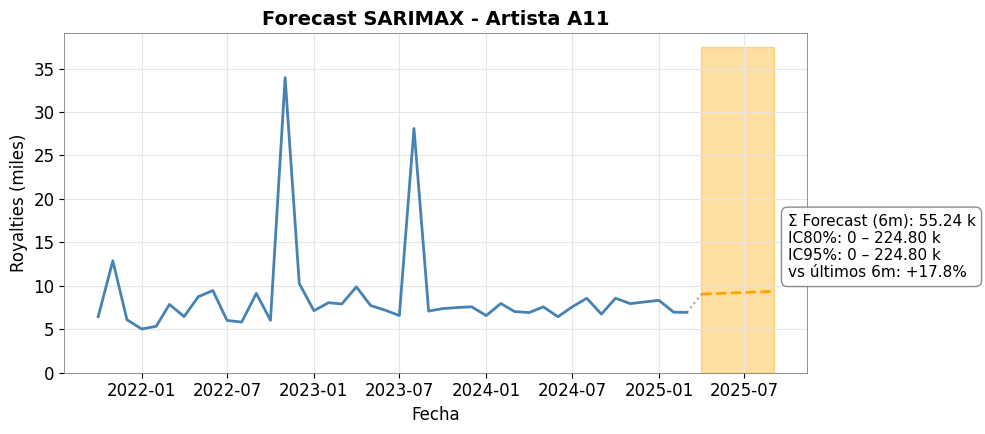

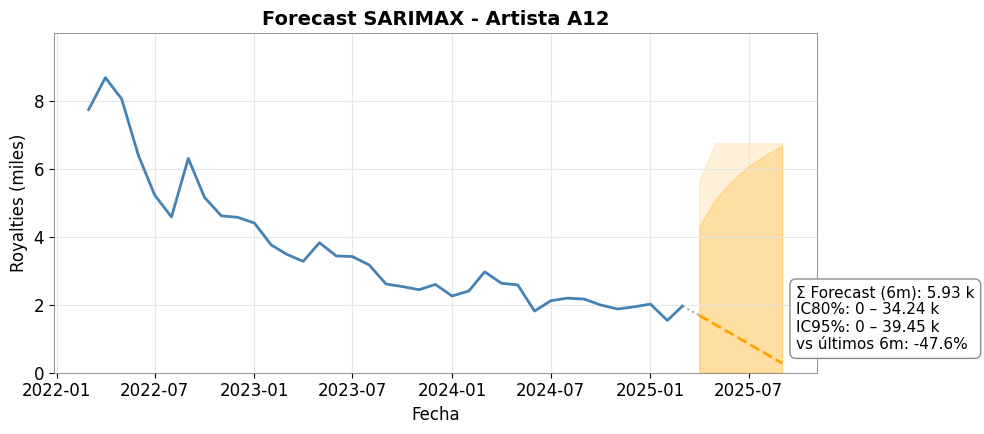

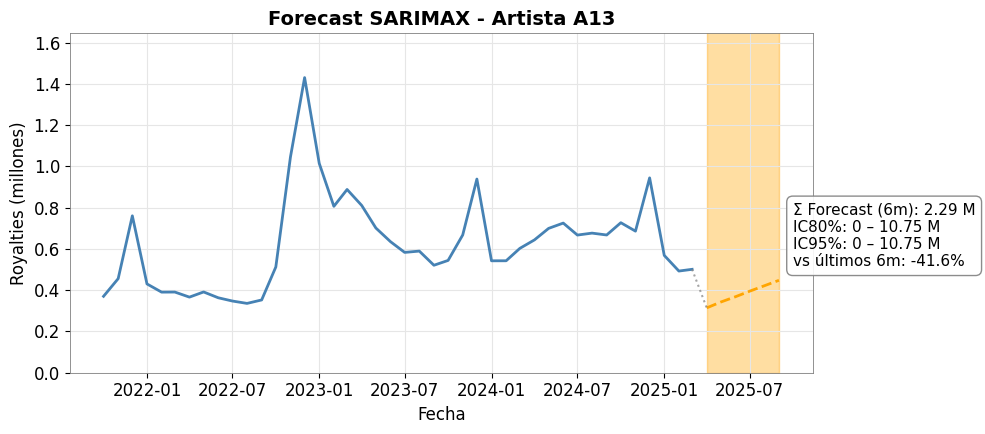

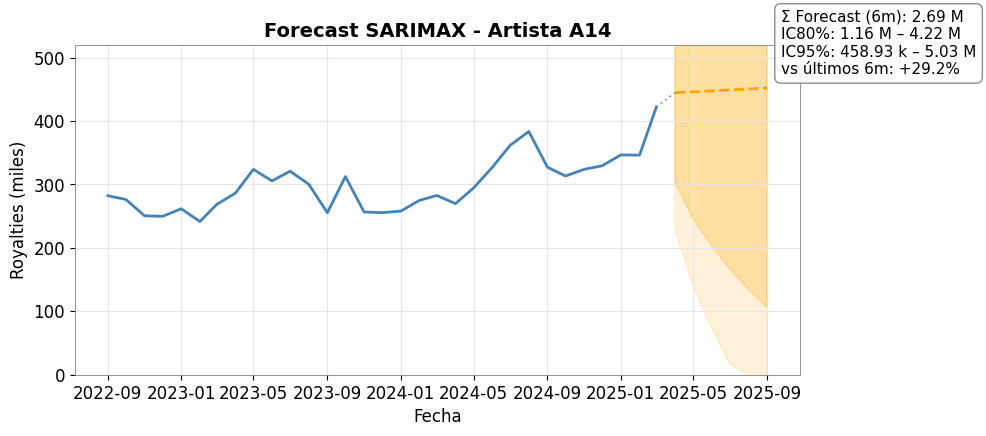

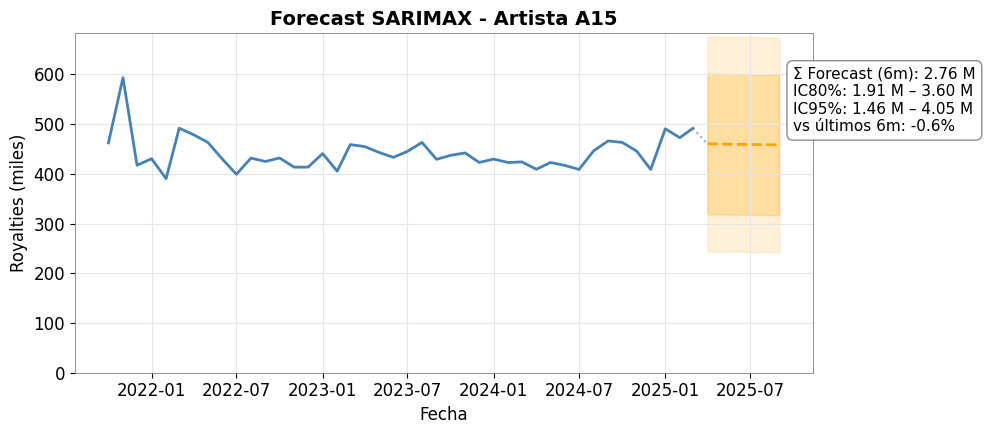

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# CARGA DE DATOS
# ==============================
df["fecha"] = pd.to_datetime(df["fecha"])
forecast = pd.DataFrame(forecast_lstm_style)

# ==============================
# CONFIG GRÁFICA GLOBAL
# ==============================
plt.rcParams.update({
    "font.size": 12,
    "figure.figsize": (10, 4.5),
    "axes.grid": True,
    "axes.edgecolor": "gray",
    "axes.linewidth": 0.6
})

# ==============================
# FUNCIONES AUXILIARES
# ==============================
def _clip_nonneg(g_fc, cols=("forecast_royalties","lo80","hi80","lo95","hi95")):
    """Evita valores negativos en forecast e intervalos"""
    g_fc = g_fc.copy()
    for c in cols:
        if c in g_fc.columns:
            g_fc[c] = pd.to_numeric(g_fc[c], errors="coerce").clip(lower=0)
    return g_fc

def _cap_intervals(g_fc, mult=4.0):
    """Capea bandas de confianza para evitar escalas absurdas"""
    f = g_fc.copy()
    core = max(f["forecast_royalties"].max(), 1e-12)
    cap = mult * core
    for lo, hi in [("lo80","hi80"), ("lo95","hi95")]:
        if lo in f.columns and hi in f.columns:
            f[lo] = pd.to_numeric(f[lo], errors="coerce").clip(lower=0, upper=cap)
            f[hi] = pd.to_numeric(f[hi], errors="coerce").clip(lower=0, upper=cap)
    return f

def _human_scale(max_val):
    """Determina la escala (miles / millones) para el eje Y"""
    if max_val >= 1e6:
        return 1e6, "Royalties (millones)"
    elif max_val >= 1e3:
        return 1e3, "Royalties (miles)"
    else:
        return 1, "Royalties"

def _fmt_money(x):
    """Formatea montos con sufijos legibles"""
    if x >= 1e6:
        return f"{x/1e6:,.2f} M"
    if x >= 1e3:
        return f"{x/1e3:,.2f} k"
    return f"{x:,.0f}"

# ==============================
# LOOP POR ARTISTA
# ==============================
for artist_id in forecast["artist_id"].unique():
    g_hist = df[df["artist_id"] == artist_id].sort_values("fecha")
    g_fc = forecast[forecast["artist_id"] == artist_id].sort_values("fecha")

    if g_hist.empty or g_fc.empty:
        continue

    # Sanitizar forecast e intervalos
    g_fc = _clip_nonneg(g_fc)
    g_fc = _cap_intervals(g_fc, mult=4.0)

    # Escala automática SOLO con histórico + forecast (sin ICs)
    core_max = max(g_hist["royalties"].max(), g_fc["forecast_royalties"].max())
    scale, y_label = _human_scale(core_max)

    # Evitar NaNs en escalado
    core_max = max(core_max, 1e-12)

    # Sumas para resumen
    sum_fc     = float(g_fc["forecast_royalties"].sum())
    sum_lo80   = float(g_fc["lo80"].sum())
    sum_hi80   = float(g_fc["hi80"].sum())
    sum_lo95   = float(g_fc["lo95"].sum())
    sum_hi95   = float(g_fc["hi95"].sum())

    # Últimos 6 meses del histórico
    last6_hist = g_hist.tail(6)["royalties"].sum() if len(g_hist) >= 6 else np.nan
    pct_vs_last6 = (sum_fc / last6_hist - 1.0) * 100 if np.isfinite(last6_hist) and last6_hist > 0 else np.nan

    # Crear figura
    fig, ax = plt.subplots()

    # Histórico
    ax.plot(
        g_hist["fecha"], g_hist["royalties"]/scale,
        label="Histórico", color="steelblue", linewidth=2
    )

    # Forecast
    ax.plot(
        g_fc["fecha"], g_fc["forecast_royalties"]/scale,
        label="Forecast", color="orange", linestyle="--", linewidth=2
    )

    # Bandas de confianza
    ax.fill_between(
        g_fc["fecha"], g_fc["lo80"]/scale, g_fc["hi80"]/scale,
        color="orange", alpha=0.25, label="IC 80%"
    )
    ax.fill_between(
        g_fc["fecha"], g_fc["lo95"]/scale, g_fc["hi95"]/scale,
        color="orange", alpha=0.15, label="IC 95%"
    )

    # Línea de unión histórico–forecast
    ax.plot(
        [g_hist["fecha"].iloc[-1], g_fc["fecha"].iloc[0]],
        [g_hist["royalties"].iloc[-1]/scale, g_fc["forecast_royalties"].iloc[0]/scale],
        color="gray", linestyle=":", alpha=0.7
    )

    # === Textbox con resumen ===
    resumen = (
        f"Σ Forecast (6m): {_fmt_money(sum_fc)}\n"
        f"IC80%: {_fmt_money(sum_lo80)} – {_fmt_money(sum_hi80)}\n"
        f"IC95%: {_fmt_money(sum_lo95)} – {_fmt_money(sum_hi95)}"
    )
    if np.isfinite(pct_vs_last6):
        signo = "+" if pct_vs_last6 >= 0 else ""
        resumen += f"\nvs últimos 6m: {signo}{pct_vs_last6:.1f}%"

    x_text = g_fc["fecha"].iloc[-1]
    y_text = (
        g_fc["forecast_royalties"].iloc[-1]/scale
        if g_fc["forecast_royalties"].iloc[-1] > 0
        else (core_max/scale)*0.7
    )

    ax.annotate(
        resumen, xy=(x_text, y_text),
        xytext=(10, 10), textcoords="offset points",
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.9)
    )

    # === Títulos y formato ===
    #ax.set_title(f"Forecast SARIMAX - {artist_id}")
    ax.set_title(f"Forecast SARIMAX - Artista {artist_id}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Fecha")
    ax.set_ylabel(y_label)
    #ax.legend(loc="upper left")

    # Ajuste de eje y sin permitir que los IC deformen la escala
    y_top = 1.15 * core_max / scale
    ax.set_ylim(0, y_top)
    ax.ticklabel_format(style="plain", axis="y")  # sin notación científica

    ax.grid(True, which="both", color="#e6e6e6", linestyle="-", linewidth=0.8, alpha=1.0)

    fig.tight_layout()
    plt.show()
